In [7]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
import scipy
import pymc3 as pm
import theano.tensor as T

print('Running on PyMC3 v{}'.format(pm.__version__))

mpl.rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=False)
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 16

%matplotlib inline

# Better looking figures
%config InlineBackend.figure_format = 'retina'

Running on PyMC3 v3.5


564


/home/fran/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


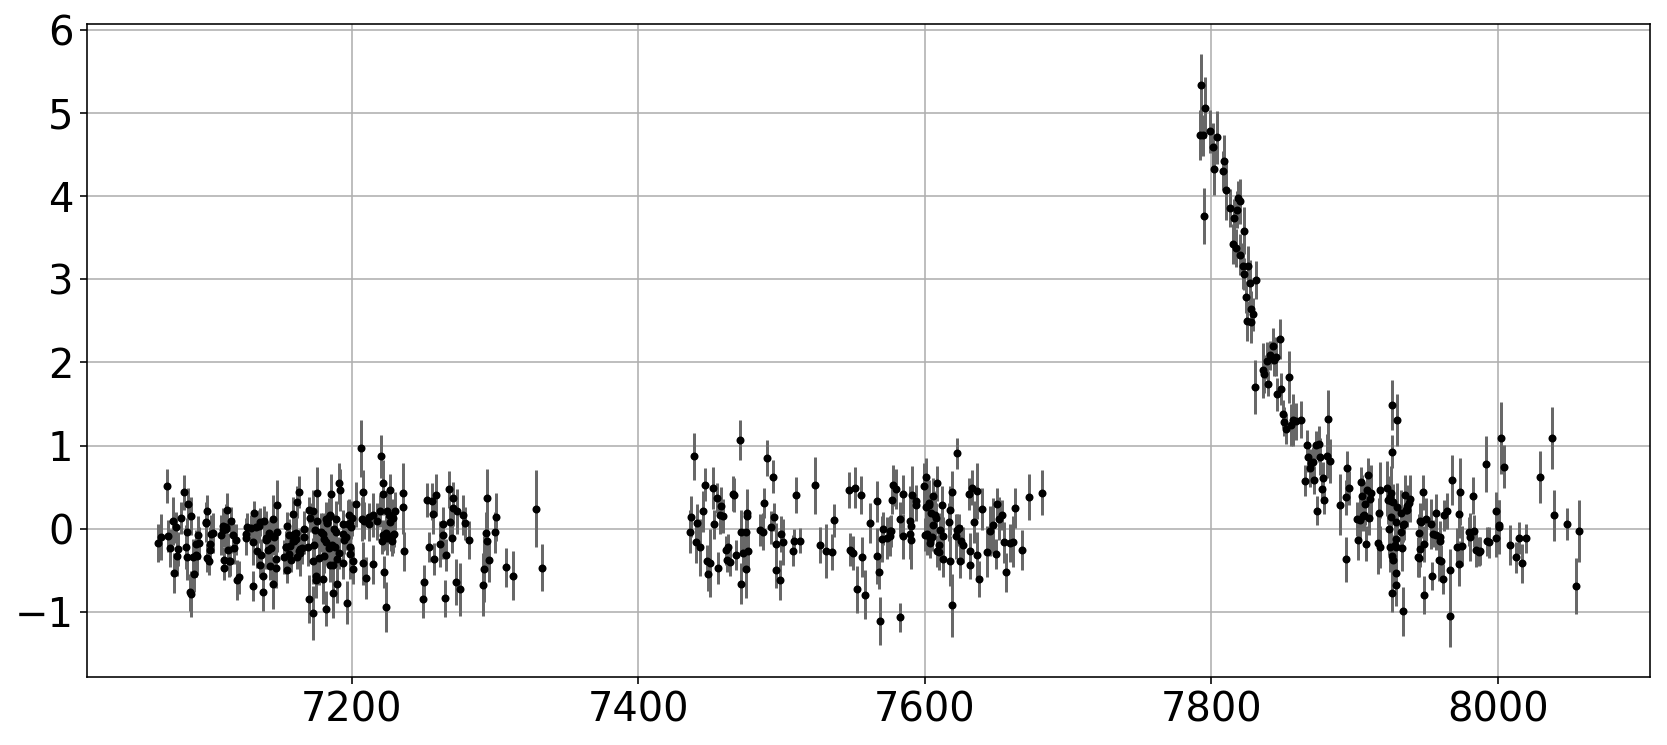

In [19]:
def plot_data(ax, x, y, y_err):
    ax.errorbar(x, y, y_err, fmt='.', color='black', label='Data', ecolor='#686868')
    ax.grid(True)

def magnitudes_to_fluxes(m, sig_m, m0):
    """Given the mean and the standard deviation of a magnitude, assumed to be normally
    distributed, and a reference magnitude m0, this function returns the mean and the 
    standard deviation of a Flux, which is log-normally distributed."""

    e = np.exp(1)
    mu_lnF = m0/(2.5*np.log10(e)) - m
    sig_lnF = sig_m/(2.5*np.log10(e))

    mu_F = np.exp(mu_lnF + 0.5*sig_lnF**2)
    sig_F = np.sqrt((np.exp(sig_lnF**2) - 1)*np.exp(2*mu_lnF + sig_lnF**2))

    return mu_F, sig_F    

def process_data(path_to_data):
    # Load data
    data = pd.read_csv(path_to_data + '/phot.dat', 
                       names=['HJD', 'I_mag', 'I_mag_err', 'seeing_est', 'sky_level'],
                       delim_whitespace=True)
    
    t = (data['HJD'].values - 2450000)
    m = data['I_mag'].values
    m_err = data['I_mag_err'].values
    
    mu_F, sig_F = magnitudes_to_fluxes(m, m_err, 22.)
    
    # Subtract the median from the data such that baseline is at approx zero
    F_r = (mu_F - np.median(mu_F))/np.std(mu_F)
    sig_F_r = sig_F/np.std(mu_F)
        
    return t, F_r, sig_F_r

fig, ax = plt.subplots(figsize=(14,6))
t, F, sigF = process_data('../microlensing_data/OGLE/2017/blg-0016/') #714
plot_data(ax, t, F, sigF)
print(len(F))

### $(\Delta F, F_b)$ parametrization
$$F=\Delta F\frac{A(u)-1}{A(u_0)-1}+F_b$$

In [ ]:
model1 = pm.Model()

with model1:    
    # log density of the joint prior for (tE, teff)
    def joint_density(value):
        teff = T.cast(value[0], 'float64')
        tE = T.cast(value[1], 'float64')
        return -T.log(tE) - (teff/tE)**2/1**2 - tE**2/200.**2
    
    # Priors for unknown model parameters
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0) # DeltaF is always positive
    DeltaF = BoundedNormal('DeltaF', mu=np.max(F), sd=1.)
    Fb = pm.Normal('Fb', mu=0., sd=0.1)
    t0 = pm.Uniform('t0', 0, 1.)
    teff_tE = pm.DensityDist('teff_tE', joint_density, shape=2, testval = [0.1, 10.])

    # Transform all variables to sensible units
    t0 = (t[-1] - t[0])*t0 + t[0]
    teff = teff_tE[0]
    tE = teff_tE[1]
    u0 = teff/tE

    # Calculate magnification
    u = np.sqrt(u0**2 + ((t - t0)/tE)**2)
    A = lambda u: (u**2 + 2)/(u*np.sqrt(u**2 + 4))

    mu = DeltaF*(A(u) - 1)/(A(u0) - 1) + Fb

    # Likelihood 
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigF, observed=F)

model1.check_test_point()
model1.vars

In [ ]:
pm.model_to_graphviz(model1)

### Sample the prior

In [ ]:
with model1:
    prior = pm.sample_prior_predictive(10000)

In [ ]:
import seaborn as sns

samples_prior = np.vstack([prior['DeltaF'],prior['Fb'],prior['t0'],prior['lnteff'],prior['lntE']]).T

# sns.distplot(prior['K'], hist=False)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

t_ = np.linspace(t[0], t[-1], 1000)

i = np.random.randint(10000)
print(i)
i = 8520
for p in samples_prior[i:i+1, :]:
    DeltaF, Fb, t0, lnteff, lntE = p
    print(p)
    teff = np.exp(lnteff)
    tE = np.exp(lntE)
    
#     teff = teff*36.5
#     tE = tE*365.
    t0 = (t[-1] - t[0])*t0 + t[0]

    u0 = teff/tE
    print(u0)
    
    u = np.sqrt(u0**2 + ((t_ - t0)/tE)**2)
    A = lambda u: (u**2 + 2)/(u*np.sqrt(u**2 + 4))
    
    mu = DeltaF*(A(u) - 1)/(A(u0) - 1) + Fb

    ax.plot(t_, mu, 'C0', alpha=0.3)

ax.set_xlim(t[0], t[-1])

### Sample the posterior

In [ ]:
t0_guess_idx = (np.abs(F - np.max(F))).argmin()

# Initialization of the chain
start = {'DeltaF':np.max(F), 'Fb':0., 't0':(t[t0_guess_idx] - t[0])/(t[-1] - t[0])}
    
with model1:
    trace1 = pm.sample(5000, tune=1000, start=start, chains=2)

# display the total number and percentage of divergent
divergent1 = trace1['diverging']
print('Number of Divergent %d' % divergent1.nonzero()[0].size)
divperc1 = divergent1.nonzero()[0].size / len(trace1)*100
print('Percentage of Divergent %.1f' % divperc1)

In [ ]:
fig, ax = plt.subplots(4,2 ,figsize=(10,10))
_ = pm.traceplot(trace1, ax=ax)

In [ ]:
pm.summary(trace1)

In [ ]:
samples1 = np.vstack([trace1['DeltaF'],trace1['Fb'],trace1['t0'],
                      trace1['teff_tE'][:, 0],trace1['teff_tE'][:, 1]]).T

quantiles = np.percentile(samples1, [16, 50, 84], axis=0)

def plot_model(t_, median_params):
    DeltaF, Fb, t0, teff, tE = median_params
    
    t0 = (t[-1] - t[0])*t0 + t[0]

    u0 = teff/tE
    
    # Expected value of outcome
    u = np.sqrt(u0**2 + ((t_ - t0)/tE)**2)
    A = lambda u: (u**2 + 2)/(u*np.sqrt(u**2 + 4))
    
    return DeltaF*(A(u) - 1)/(A(u0) - 1) + Fb


t_ = np.linspace(t[0], t[-1], 1000)

fig, ax = plt.subplots(figsize=(10, 6))

plot_data(ax, t, F, sigF)

ax.plot(t_, plot_model(t_, quantiles[1]), 
             marker='', linestyle='-', color='C0', lw=2.)
# ax.set_xlim(7800, 7925)

In [ ]:
import corner
fig = corner.corner(samples1, labels=['$\Delta F$', '$F_b$', '$t_0$', '$t_{eff}$', '$t_E$'])
fig.constrained_layout = True

In [ ]:
pm.plots.autocorrplot(trace1)

In [ ]:
pm.pairplot(trace1,
           sub_varnames=['teff','tE'],
           divergences=True,
           color='k', figsize=(5, 5), kwargs_divergence={'color':'C3'});

In [ ]:
divergent_mask = trace1['diverging']
divergent_samples = samples1[divergent_mask]
print(np.shape(divergent_samples))

fig, ax = plt.subplots(figsize=(10, 6))

plot_data(ax, t, F, sigF)

t_ = np.linspace(t[0], t[-1], 5000)

for p in divergent_samples:
    DeltaF, Fb, t0, u0, tE = p
    
    # Expected value of outcome
    u = np.sqrt(u0**2 + ((t_ - t0)/tE)**2)
    A = lambda u: (u**2 + 2)/(u*np.sqrt(u**2 + 4))
    
    F_ = DeltaF*(A(u) - 1)/(A(u0) - 1) + Fb
    ax.plot(t_, F_, 'C0', alpha=0.3)

ax.set_xlim(7860, 7880)

In [ ]:
tracedf = pm.trace_to_dataframe(trace1)
plotorder = ['DeltaF', 'Fb', 't0', 'u0', 'tE']
tracedf = tracedf[plotorder]

_, ax = plt.subplots(1, 2, figsize=(15, 4), sharex=True, sharey=True)
ax[0].plot(tracedf.values[divergent == 0].T, color='k', alpha=.025)
ax[0].plot(tracedf.values[divergent == 1].T, color='C2', lw=.5)

ax[1].plot(tracedf.values[divergent == 0].T, color='k', alpha=.025)
ax[1].plot(tracedf.values[divergent == 1].T, color='C2', lw=.5)
# divsp = np.hstack([divergent_point['mu'][:,None],
#                    np.exp(divergent_point['tau_log__'])[:,None],
#                    divergent_point['theta']])
ax[1].plot(divsp.T, 'C3', lw=.5)
plt.ylim([-20,40])
plt.xticks(range(10), plotorder)
plt.tight_layout();

# Fitting a GP with pymc3

In [20]:
from theano.tensor import _shared

# Define custom mean function
class mean_model():
    def __init__(self, DeltaF, Fb, t0, teff, tE):
        pm.gp.mean.Mean.__init__(self)
        self.DeltaF = DeltaF
        self.Fb = Fb
        self.t0 = t0
        self.teff = teff
        self.tE = tE
        
    def __call__(self, F):
        F = _shared(F)
        t_ = _shared(t)
        
        # Transform all variables to sensible units
        self.t0 = (t_[-1] - t_[0])*self.t0 + t_[0]
        u0 = self.teff/self.tE

        # Calculate magnification
        u = T.sqrt(u0**2 + ((t_ - self.t0)/self.tE)**2)
        A = lambda u: (u**2 + 2)/(u*np.sqrt(u**2 + 4))

        return self.DeltaF*(A(u) - 1)/(A(u0) - 1) + self.Fb

In [21]:
with pm.Model() as gp_model:
    # log density of the joint prior for (tE, teff)
    def joint_density(value):
        teff = T.cast(value[0], 'float64')
        tE = T.cast(value[1], 'float64')
        return -T.log(tE) - (teff/tE)**2/1**2 - tE**2/200.**2
    
    # Priors for unknown model parameters
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0) # DeltaF is always positive
    DeltaF = BoundedNormal('DeltaF', mu=np.max(F), sd=1.)
    Fb = pm.Normal('Fb', mu=0., sd=0.1)
    t0 = pm.Uniform('t0', 0, 1.)
    teff_tE = pm.DensityDist('teff_tE', joint_density, shape=2, testval = [0.1, 10.])
    
    # Specify the mean function
    mean_func = mean_model(DeltaF, Fb, t0, teff_tE[0], teff_tE[1])
    
    # Specify the covariance function.
    l = BoundedNormal('l', mu=200., sd= 150)
    eta = pm.Normal('eta', mu=0., sd=2.)
    cov_func = eta**2 * pm.gp.cov.ExpQuad(1, l)

    # Specify the GP
    gp = pm.gp.Marginal(mean_func, cov_func)

    F_ = gp.marginal_likelihood("F", X=t[:, None], y=F, noise=sigF)

In [22]:
gp_model.check_test_point()
gp_model.vars

[DeltaF_lowerbound__, Fb, t0_interval__, teff_tE, l_lowerbound__, eta]

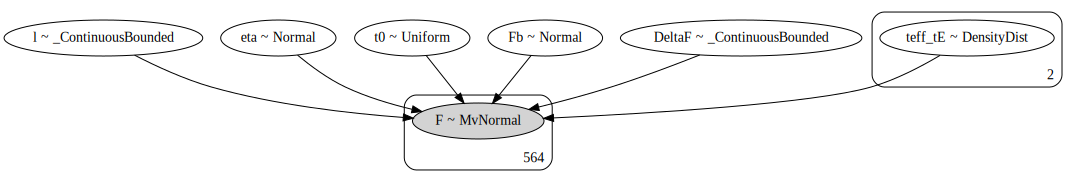

In [23]:
pm.model_to_graphviz(gp_model)

In [25]:
t0_guess_idx = (np.abs(F - np.max(F))).argmin()

# Initialization of the chain
start = {'DeltaF':np.max(F), 'Fb':0., 't0':(t[t0_guess_idx] - t[0])/(t[-1] - t[0])}

map_estimate = pm.find_MAP(model=gp_model, start=start)

map_estimate

logp = -352.68, ||grad|| = 0.24348: 100%|██████████| 86/86 [00:04<00:00, 19.15it/s]  


{'DeltaF_lowerbound__': array(1.575183653373826),
 'Fb': array(-0.10737999542547193),
 't0_interval__': array(1.023211377170829),
 'teff_tE': array([ 41.40487284,  50.2141249 ]),
 'l_lowerbound__': array(0.05988148171342739),
 'eta': array(0.0),
 'DeltaF': array(4.831628881578497),
 't0': array(0.7355976646071078),
 'l': array(1.0617107069545366)}

In [27]:
mp = [float(map_estimate["DeltaF"]), float(map_estimate["Fb"]), float(map_estimate["t0"]),
float(map_estimate["teff_tE"][0]), float(map_estimate["teff_tE"][1]), float(map_estimate["l"]), float(map_estimate["eta"])]

In [29]:
# new values from x=0 to x=20
X_new = np.linspace(t[0], t[-1], 564)[:,None]

# predict
mu, var = gp.predict(X_new, point=mp, diag=True)
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X_new, mu, 'r', lw=2, label="mean and 2σ region");
plt.plot(X_new, mu + 2*sd, 'r', lw=1); plt.plot(X_new, mu - 2*sd, 'r', lw=1);
plt.fill_between(X_new.flatten(), mu - 2*sd, mu + 2*sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data");
plt.plot(X, f_true, "dodgerblue", lw=3, label="true f");

plt.xlabel("x"); plt.ylim([-13,13]);
plt.title("predictive mean and 2σ interval"); plt.legend();

ValueError: Distribution was not passed any random method Define a custom random method and pass it as kwarg random

In [ ]:
t0_guess_idx = (np.abs(F - np.max(F))).argmin()

# Initialization of the chain
start = {'DeltaF':np.max(F), 'Fb':0., 't0':(t[t0_guess_idx] - t[0])/(t[-1] - t[0])}
    
with gp_model:
    trace_gp = pm.sample(200, tune=100, start=start, chains=2)

# display the total number and percentage of divergent
divergent1 = trace1['diverging']
print('Number of Divergent %d' % divergent1.nonzero()[0].size)
divperc1 = divergent1.nonzero()[0].size / len(trace1)*100
print('Percentage of Divergent %.1f' % divperc1)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eta, l, teff_tE, t0, Fb, DeltaF]
Sampling 2 chains:   0%|          | 0/600 [00:00<?, ?draws/s]